<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Гипотеза:

Если найти подходящий способ описания концентрации частиц в заданной области (сейчас используется интерполяция, здесь Gaussian Rbf) - можно смоделировать распространение выброса по 3 точкам во времени, используя VAE и/или другую архитектуру. См. пример ниже.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
import random
import tensorflow as tf
from tqdm.keras import TqdmCallback
models = tf.keras.models
layers = tf.keras.layers
np.random.seed(17)

from attention import Attention 

In [2]:
SAMPLES = np.load('SAMPLES2_gS4t',allow_pickle=True) # интерполяция 3 точки + 4 для предсказания

In [3]:
io_shape_x =(39, 39*3)
io_shape_y =(39*39)

In [4]:
X, Y = [], []

inds = list(range(0, len(SAMPLES)))
random.shuffle(inds)

# Test at the end
for ind in tqdm(inds):
    sample = SAMPLES[ind]
    x = np.zeros(io_shape_x)
    x[:, :39] = np.where(sample[0] > 0, sample[0], np.abs(sample[0]))
    x[:, 39:39 * 2] = np.where(sample[1] > 0, sample[1], np.abs(sample[1]))
    x[:, 39 * 2:] = np.where(sample[2] > 0, sample[2], np.abs(sample[2]))

    y = np.where(sample[3] > 0, sample[2], np.abs(sample[3]))

    X.append(x.copy().reshape(io_shape_x))
    Y.append(y.copy().flatten().reshape(io_shape_y))

sample[2].flatten()

  0%|          | 0/6588 [00:00<?, ?it/s]

array([ 0.02681696,  0.0242134 ,  0.02068671, ...,  0.00335298,
        0.00127193, -0.00019498])

Text(0.5, 1.0, 't0-40')

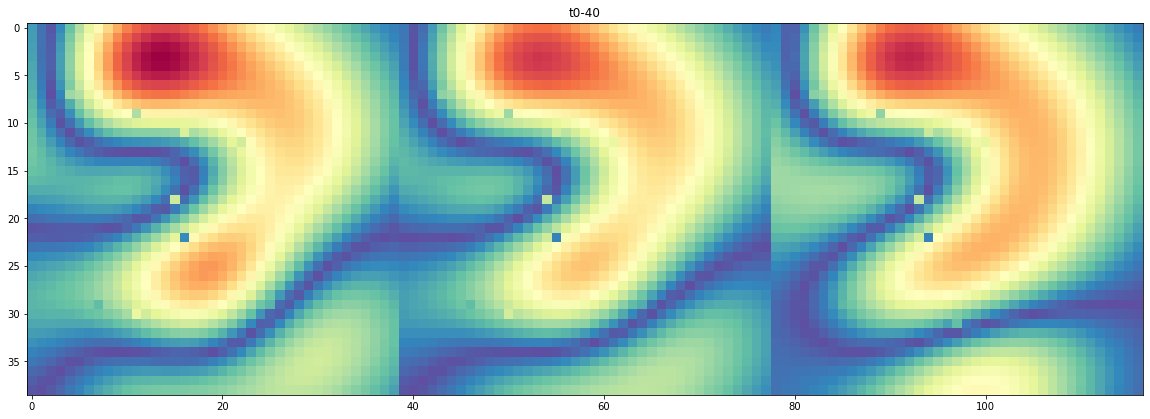

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(X[10], cmap='Spectral_r')
plt.title('t0-40')

Text(0.5, 1.0, 't60')

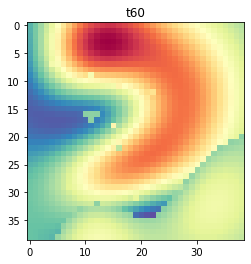

In [6]:
plt.imshow(Y[10].reshape(39,39), cmap='Spectral_r')
plt.title('t60')

In [7]:
X_test = np.array(X[-100:])
Y_test = np.array(Y[-100:])
X = np.array(X[:-100])
Y = np.array(Y[:-100])
X.shape

(6488, 39, 117)

In [8]:
def get_model(input_len=(39, 117)):
    model_input = layers.Input(shape=input_len)
    x = layers.Bidirectional(layers.LSTM(32,
                                         return_sequences=True))(model_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = Attention(32)(x)
    x = layers.Dense(39 * 39)(x)
    model = models.Model(model_input, x)
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())

    return model

In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
model = get_model(io_shape_x)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 39, 117)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 39, 64)       38400       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 39, 64)       0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 39, 64)       24832       dropout[0][0]                    
______________________________________________________________________________________________

In [11]:
history = model.fit(X,
        Y,
        verbose=0,
        epochs=30,
        batch_size=32,
        callbacks=[TqdmCallback(), lr_scheduler],
        shuffle=True,
        validation_split=0.1)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

In [13]:
from utils import rename, propagate

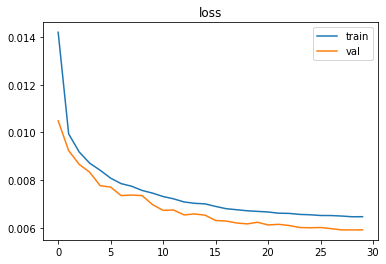

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('loss');

In [15]:
pos = {'Академика Анохина': (29, 7),
 'Бутлерова ': (30, 11),
 'Глебовская ': (12, 22),
 'Коптевский бул ': (9, 11),
 'Марьино': (29, 25),
 'Останкино ': (11, 16),
 'Пролетарский проспект ': (31, 19),
 'Спиридоновка': (18, 15),
 'Туристская ': (7, 4),
 'Шаболовка ': (22, 16)}

TRAIN


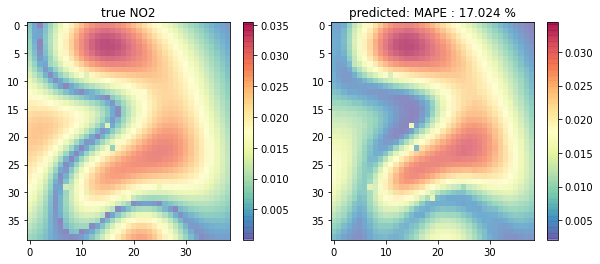

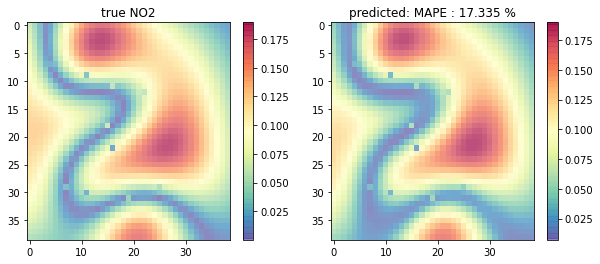

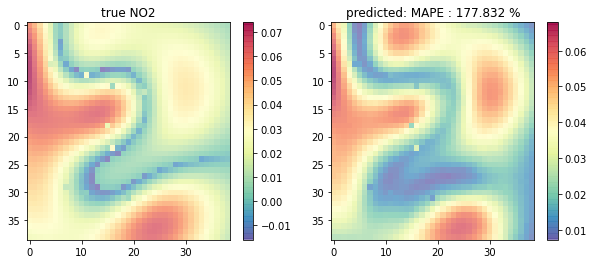

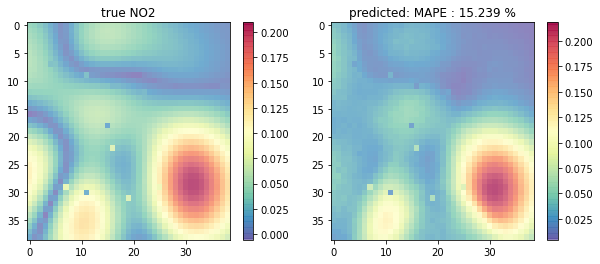

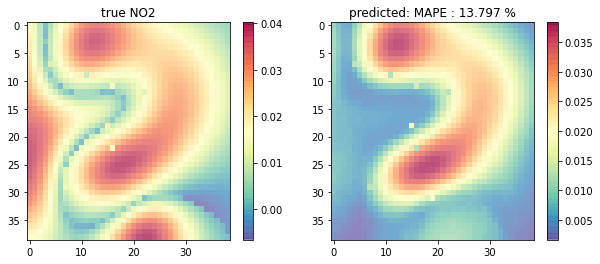

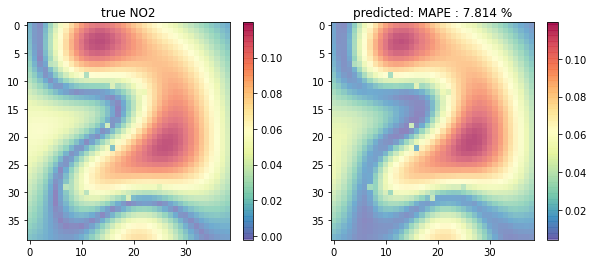

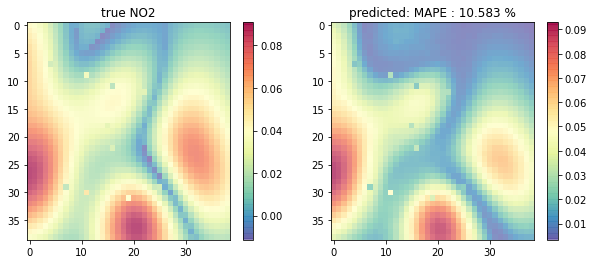

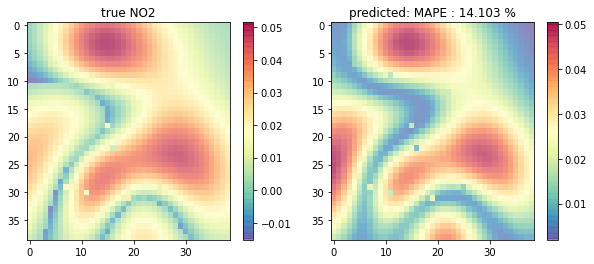

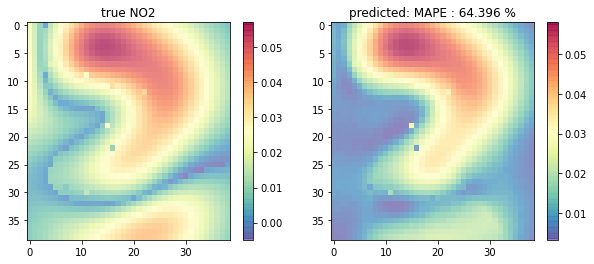

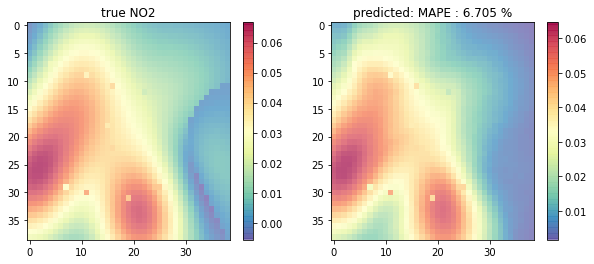

In [16]:
# ON TRAIN
print('TRAIN')
K = 1
for i in range(1, 1000,100):
    xx = X[X.shape[0] - i:, :, :]
    pred = model.predict(xx)[0].reshape((39, 39))
    true = Y[X.shape[0] - i:][0].reshape((39, 39))
    t, p = [], []
    for name, coords in pos.items():
        t.append(true[coords])
        p.append(pred[coords])

    t = np.array(t)
    p = np.array(p)
    error = mean_absolute_percentage_error(t, p) * 100

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.imshow(true, aspect='auto', alpha=0.7, cmap='Spectral_r')
    plt.title('true NO2')
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(pred, aspect='auto', alpha=0.7, cmap='Spectral_r')
    plt.title(f'predicted: MAPE : {round(error,3)} %')
    plt.colorbar()

TEST


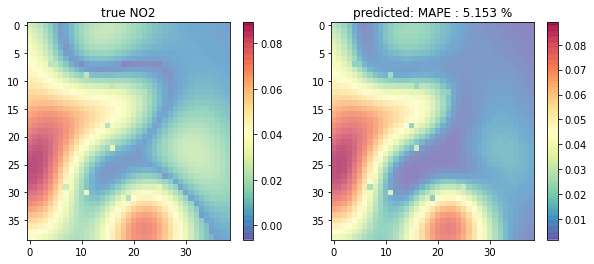

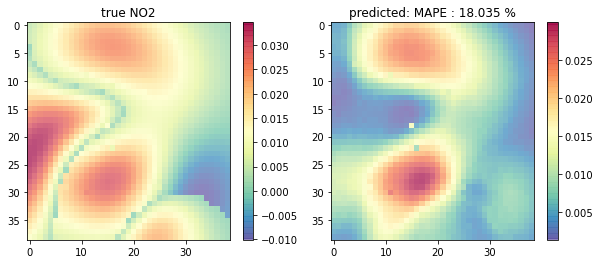

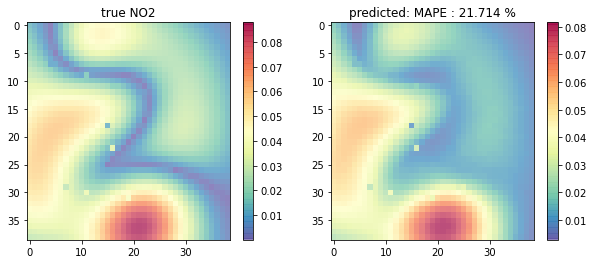

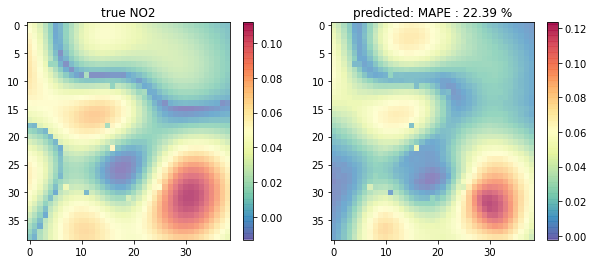

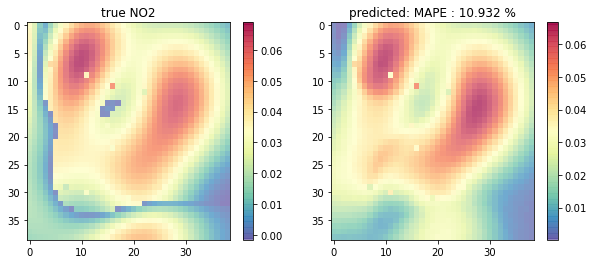

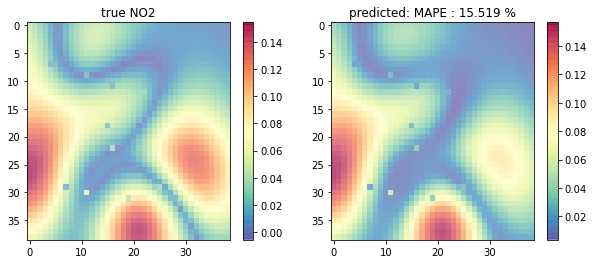

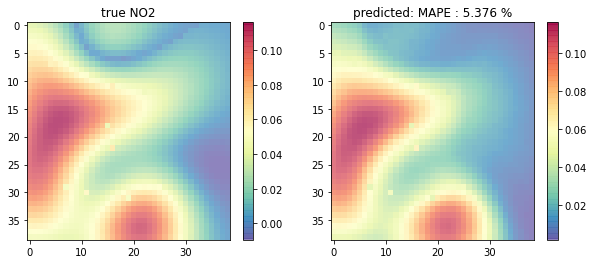

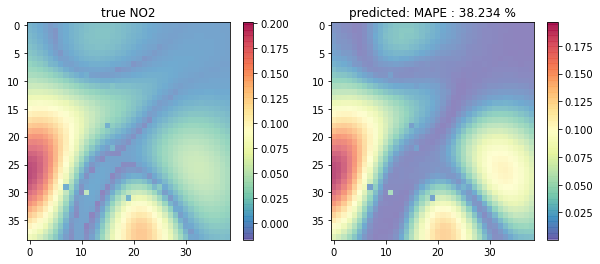

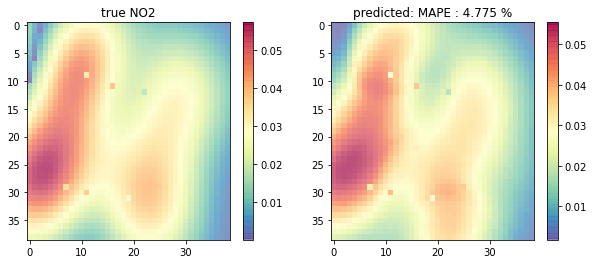

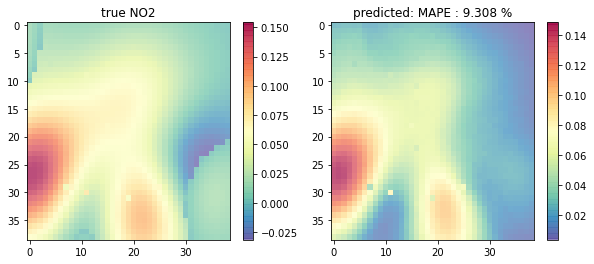

In [17]:
# ON TEST
print('TEST')
K = 1
for i in range(1, 100, 10):
    xx = X_test[X_test.shape[0] - i:, :, :]
    pred = model.predict(xx)[0].reshape((39, 39))
    true = Y_test[X_test.shape[0] - i:][0].reshape((39, 39))
    t, p = [], []
    for name, coords in pos.items():
        t.append(true[coords])
        p.append(pred[coords])

    t = np.array(t)
    p = np.array(p)
    error = mean_absolute_percentage_error(t, p) * 100

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.imshow(true, aspect='auto', alpha=0.7, cmap='Spectral_r')
    plt.title('true NO2')
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(pred, aspect='auto', alpha=0.7, cmap='Spectral_r')
    plt.title(f'predicted: MAPE : {round(error,3)} %')
    plt.colorbar()

In [18]:
t0 = {'Академика Анохина': 0.015, 'Бутлерова': 0.00824, 'Глебовская': 0.0203, 'Коптевский бул': 0.014, 'Марьино': 0.0244, 'Останкино': 0.008, 'Пролетарский проспект': 0.0086, 'Спиридоновка': 0.024, 'Туристская': 0.017, 'Шаболовка': 0.015}
t20 ={'Академика Анохина': 0.013, 'Бутлерова': 0.005220000000000001, 'Глебовская': 0.02, 'Коптевский бул': 0.011, 'Марьино': 0.0232, 'Останкино': 0.006, 'Пролетарский проспект': 0.0047, 'Спиридоновка': 0.024, 'Туристская': 0.017, 'Шаболовка': 0.0126}
t40 ={'Академика Анохина': 0.013, 'Бутлерова': 0.0058000000000000005, 'Глебовская': 0.0195, 'Коптевский бул': 0.009, 'Марьино': 0.02, 'Останкино': 0.007, 'Пролетарский проспект': 0.005, 'Спиридоновка': 0.024, 'Туристская': 0.017, 'Шаболовка': 0.0129}

In [19]:
from scipy import interpolate


def render_linear(mat):

    mat_save = mat.copy()
    P = np.nonzero(mat)
    x, y, z = [], [], []
    for i, j in zip(P[0], P[1]):
        x.append(i)
        y.append(j)
        z.append(mat[i, j])

    interp = interpolate.Rbf(x, y, z, function='linear')
    grid = np.mgrid[0:39, 0:39]
    result = interp(grid[0, :, :], grid[1, :, :])
    mat = np.where(mat_save != 0, mat_save, mat)
    return result

In [20]:
first_state = np.zeros(shape=(39, 39))
second_state = np.zeros(shape=(39, 39))
third_state = np.zeros(shape=(39, 39))

for name, coords in pos.items():
    first_state[coords] = t0[name.strip()]
    second_state[coords] = t20[name.strip()]
    third_state[coords] = t40[name.strip()]

third_state[20, 20] = 0.04  # puff

In [21]:
first_state = render_linear(first_state)
second_state = render_linear(second_state)
third_state = render_linear(third_state)

x = np.zeros(io_shape_x)
x[:, :39] = first_state
x[:, 39:39 * 2] = second_state
x[:, 39 * 2:] = third_state

fourth_state = model.predict(x.reshape(1, 39, 117)).reshape((39, 39))

x = np.zeros(io_shape_x)
x[:, :39] = second_state
x[:, 39:39 * 2] = third_state
x[:, 39 * 2:] = fourth_state

fith_state = model.predict(x.reshape(1, 39, 117)).reshape((39, 39))

x = np.zeros(io_shape_x)
x[:, :39] = third_state
x[:, 39:39 * 2] = fourth_state
x[:, 39 * 2:] = fith_state

sixth_state = model.predict(x.reshape(1, 39, 117)).reshape((39, 39))

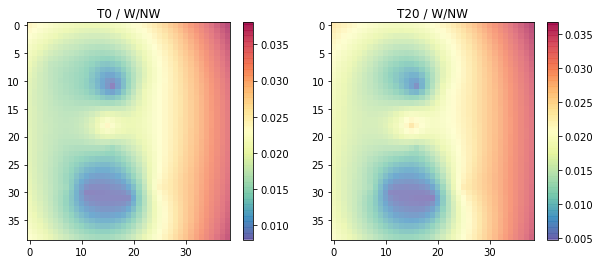

In [22]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(first_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title('T0 / W/NW')
plt.colorbar()

plt.subplot(122)
plt.imshow(second_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title(f'T20 / W/NW')
plt.colorbar()

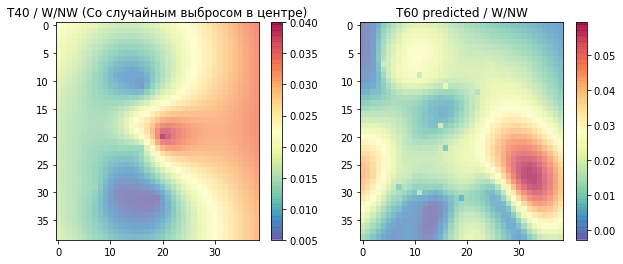

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(third_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title(f'T40 / W/NW (Со случайным выбросом в центре)')
plt.colorbar()

plt.subplot(122)
plt.imshow(fourth_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title(f'T60 predicted / W/NW')
plt.colorbar()

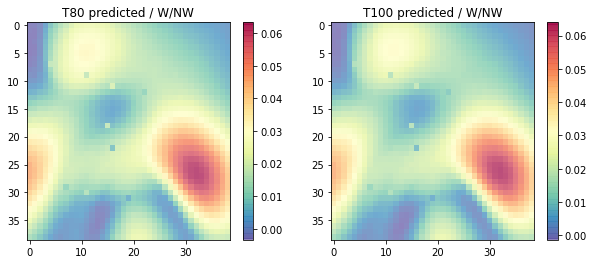

In [24]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(fith_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title(f'T80 predicted / W/NW')
plt.colorbar()

plt.subplot(122)
plt.imshow(sixth_state, aspect='auto', alpha=0.7, cmap='Spectral_r')
plt.title(f'T100 predicted / W/NW')
plt.colorbar()